In [1]:
import pandas as pd
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

In [2]:
accidents = pd.read_csv("../PrometneNesreče.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_19236\901670543.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents = pd.read_csv("../PrometneNesreče.csv")


In [3]:
# Priprava podatkov
accidents['NastanekDatumCas'] = pd.to_datetime(accidents['NastanekDatumCas'], format='ISO8601', errors='coerce')
print(f"NastanekDatumCas column dtype: {accidents['NastanekDatumCas'].dtype}")

NastanekDatumCas column dtype: datetime64[ns]


# CosinorPy - pomlad

In [4]:
spring_mask = accidents['NastanekDatumCas'].dt.month.isin([3, 4, 5])

spring_accidents = accidents[spring_mask]
# print(f"NastanekDatumCas column dtype: {spring_accidents['NastanekDatumCas'].dtype}")

hours = spring_accidents['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()
accidents_per_hour = accidents_per_hour.sort_index()

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsSpring",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

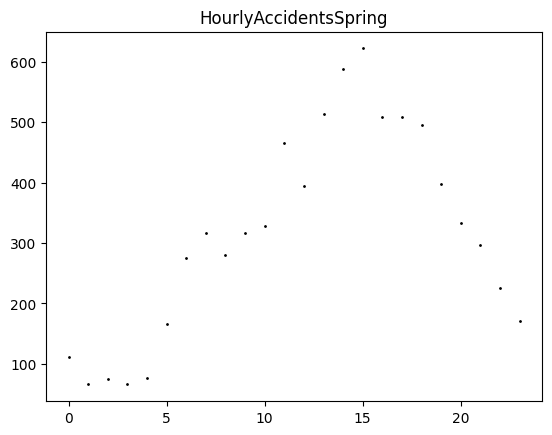

In [5]:
cosinor.plot_data(df_plot, names=["HourlyAccidentsSpring"])

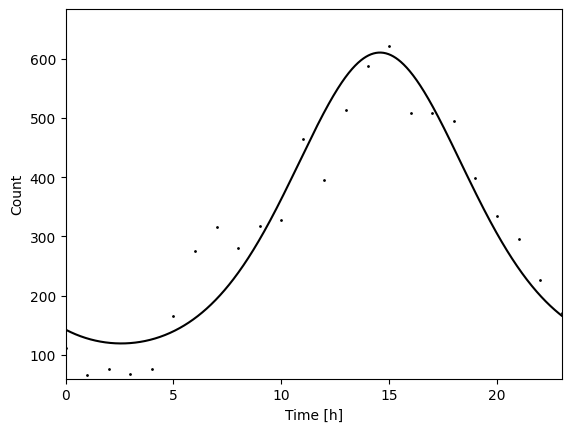

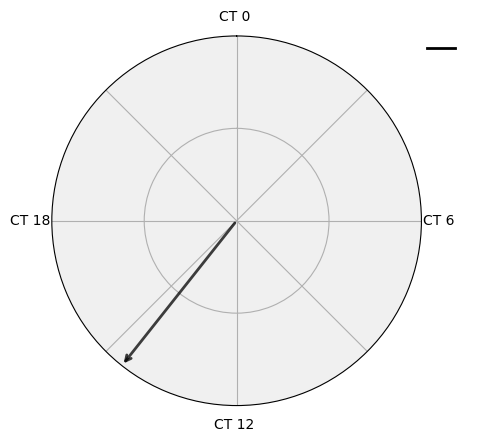

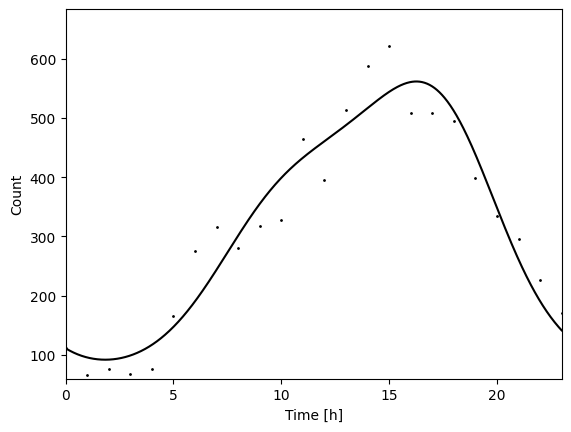

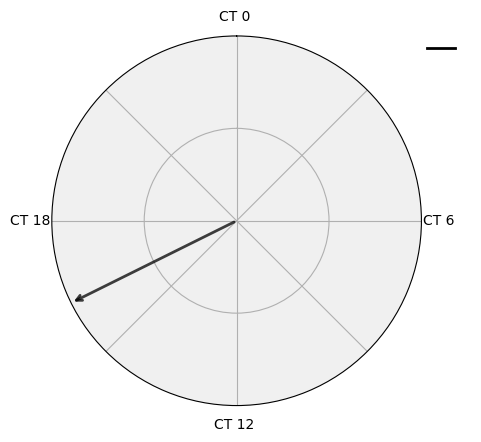

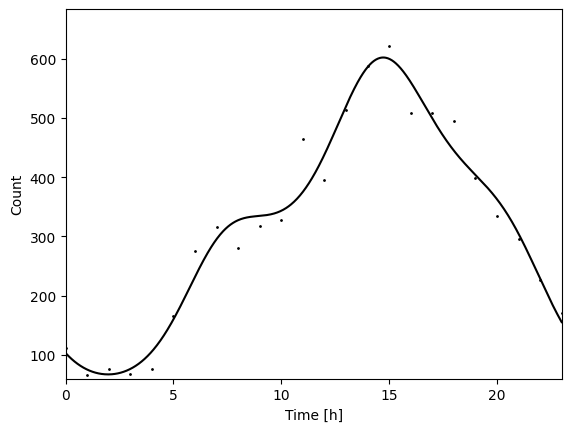

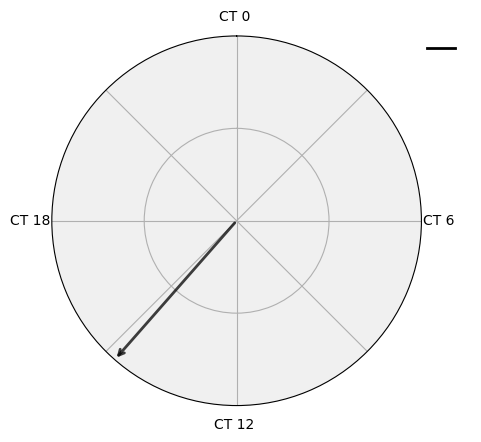

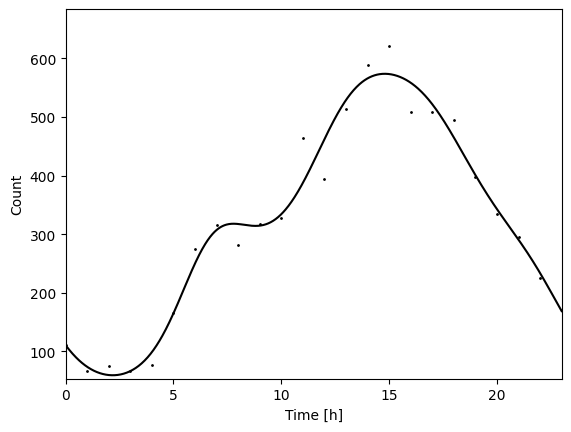

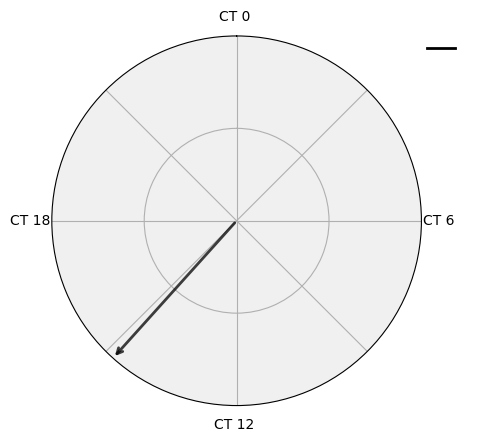

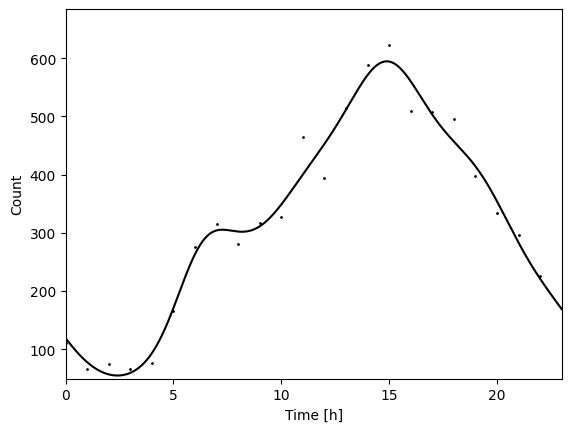

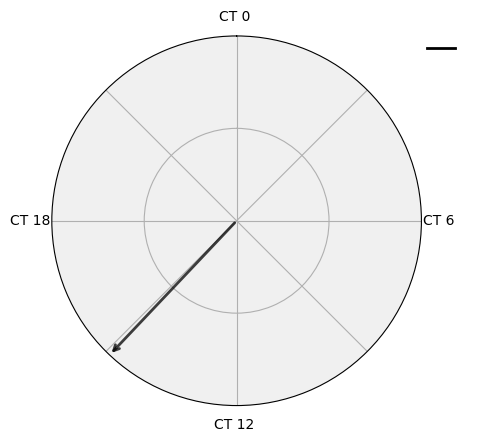

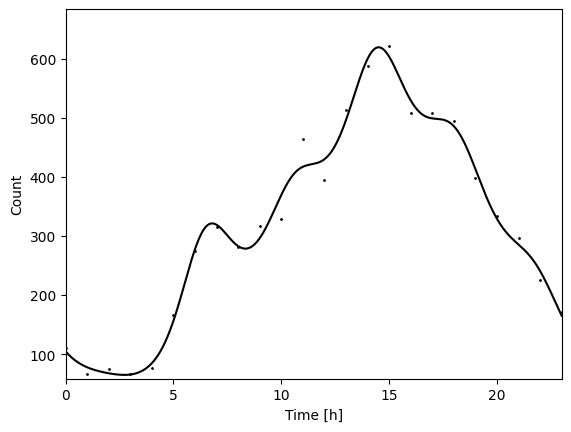

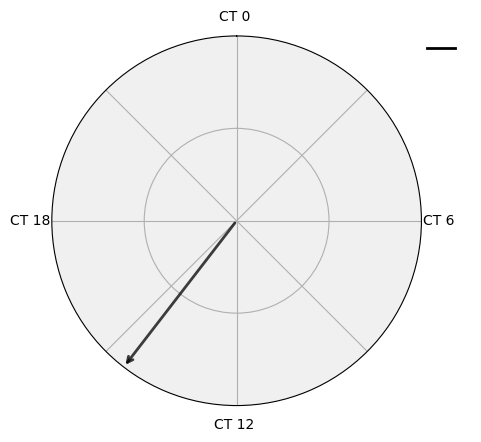

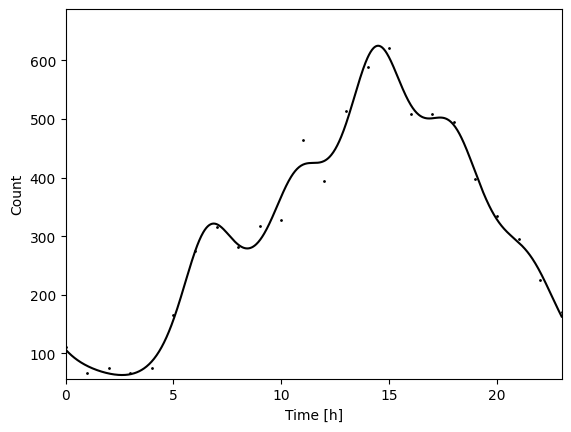

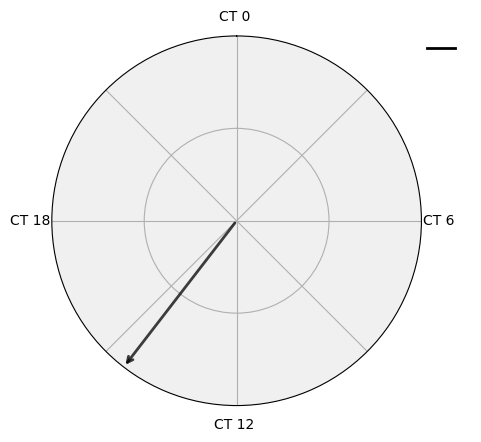

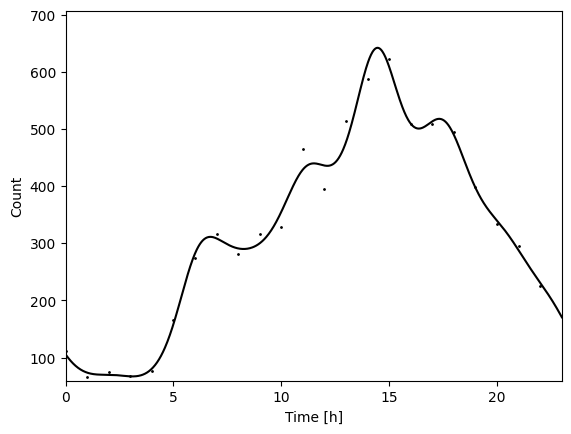

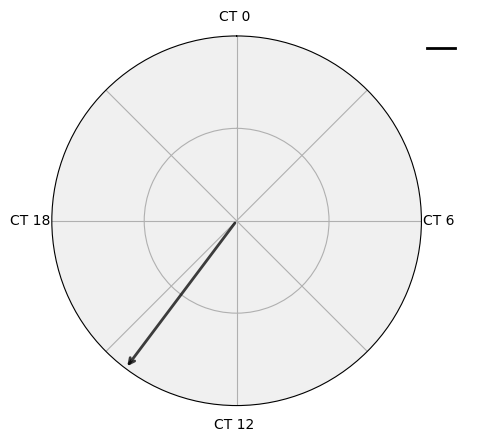

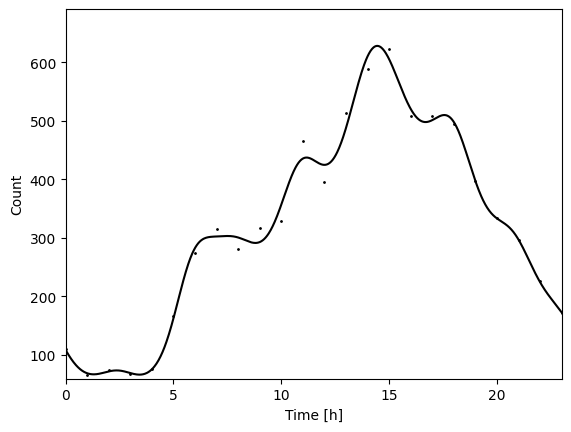

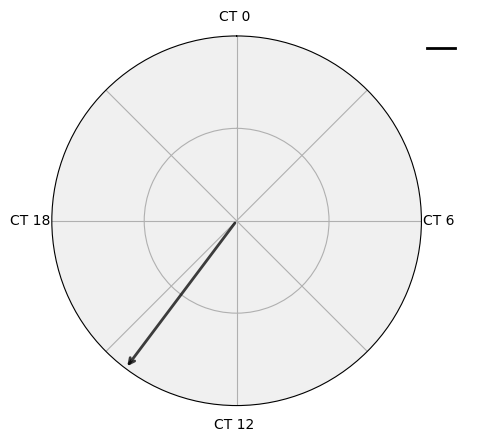

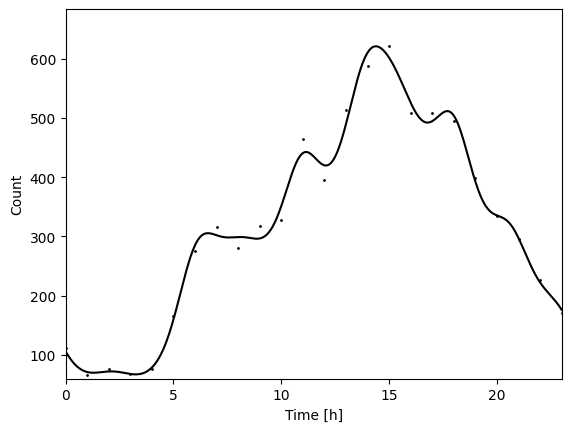

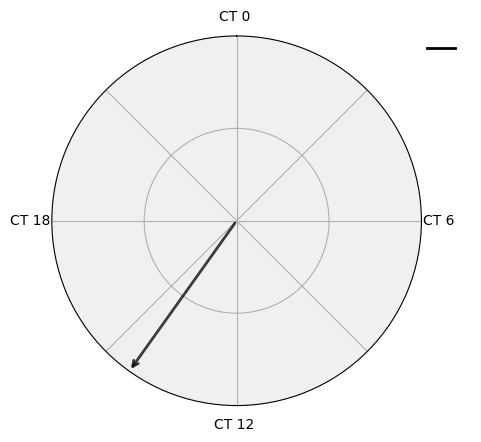

In [6]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)


numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in numbers:
    results, statistics, rhythm_param, _, _ = cosinor.fit_me(X, Y, n_components = i, period = 24, model_type = 'gen_poisson', plot_margins=False)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))

    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsSpring', 
        'period': 24,
        'n_components': i,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })


df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

In [7]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsSpring,24.0,1.0,1.768213e-12,1.768213e-12,73216.509012,-131.820025,0.170323,245.869564,2.471764,364.907539,[14.558558558558559],[610.7732223292846],[2.5945945945945947],[119.03914357412924]
1,HourlyAccidentsSpring,24.0,2.0,4.400797e-14,4.889775e-14,50873.122634,-124.562256,0.216003,235.163213,2.031500,326.722201,[16.24024024024024],[561.8799747733152],[1.8258258258258258],[91.55898754756568]
2,HourlyAccidentsSpring,24.0,3.0,2.287278e-17,3.267540e-17,23080.113524,-113.587152,0.285081,267.856821,2.421448,334.564761,[14.75075075075075],[602.4046086325056],[1.96996996996997],[66.70793954337299]
3,HourlyAccidentsSpring,24.0,4.0,2.204461e-17,3.267540e-17,20184.654253,-110.627154,0.303711,257.250368,2.408869,316.580018,"[7.783783783783783, 14.7987987987988]","[317.9258995573223, 573.830385730096]","[2.1621621621621623, 8.792792792792794]","[59.333870825557554, 314.2275116520797]"
4,HourlyAccidentsSpring,24.0,5.0,3.835858e-17,4.794822e-17,15665.120167,-108.500182,0.317098,269.813226,2.383711,324.754987,[14.894894894894895],[594.5682125148328],"[2.4024024024024024, 8.168168168168169]","[54.941761368675365, 301.85882660311285]"
5,HourlyAccidentsSpring,24.0,6.0,3.079155e-19,3.079155e-18,8081.816933,-100.632450,0.366618,277.357329,2.484343,342.195805,[14.51051051051051],[619.55313415149],"[2.7387387387387387, 8.312312312312311]","[64.8413150974067, 278.6568993292797]"
6,HourlyAccidentsSpring,24.0,7.0,2.233313e-18,5.039962e-18,7433.193503,-100.287591,0.368788,280.931380,2.484343,344.171413,"[14.51051051051051, 17.345345345345343]","[625.0639772706046, 502.58143550328333]","[2.5945945945945947, 8.408408408408409]","[63.24258366131867, 279.23478953057366]"
7,HourlyAccidentsSpring,24.0,8.0,1.008588e-18,3.361961e-18,6824.036402,-96.970686,0.389665,287.658143,2.496921,354.618537,"[11.531531531531531, 14.462462462462462, 17.29...","[439.92003579239605, 642.2766800400032, 517.89...","[3.075075075075075, 8.264264264264265]","[66.96360396795183, 290.056304737458]"
8,HourlyAccidentsSpring,24.0,9.0,7.460056e-19,3.361961e-18,5486.992667,-94.269154,0.406668,280.805333,2.496921,347.175367,"[11.147147147147146, 14.462462462462462, 17.53...","[437.2108103298674, 627.9783555881769, 509.842...","[1.2972972972972974, 3.4114114114114114, 8.792...","[66.8917691991719, 66.37003430063922, 291.3479..."
9,HourlyAccidentsSpring,24.0,10.0,2.519981e-18,5.039962e-18,5014.943475,-93.376445,0.412287,277.320468,2.522079,344.055910,"[11.147147147147146, 14.366366366366366, 17.68...","[442.6867595152428, 621.3553461919996, 511.784...","[1.2972972972972974, 3.2672672672672673, 7.591...","[69.50768345941302, 66.74073600025145, 298.165..."


### Katero je najboljše število komponent

In [8]:
df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsSpring,24.0,6.0,3.079155e-19,3.079155e-18,8081.816933,-100.63245,0.366618,277.357329,2.484343,342.195805,[14.51051051051051],[619.55313415149],"[2.7387387387387387, 8.312312312312311]","[64.8413150974067, 278.6568993292797]"


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1659: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


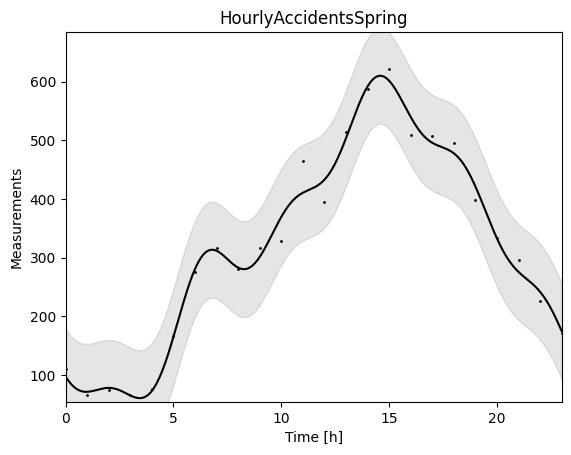

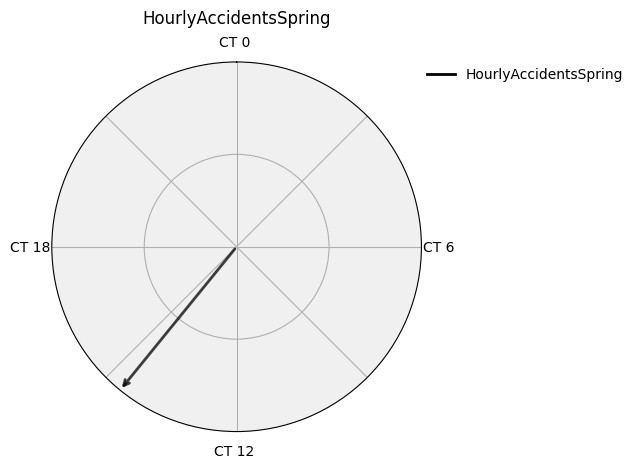

In [9]:
cosinor.plot_df_models(df_plot, df_best_model)

## RhythmCount

In [10]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_plot_RC = pd.DataFrame({
    "test": "HourlyAccidentsSpring",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour.values  # Število nesreč za tisto uro
})

In [11]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

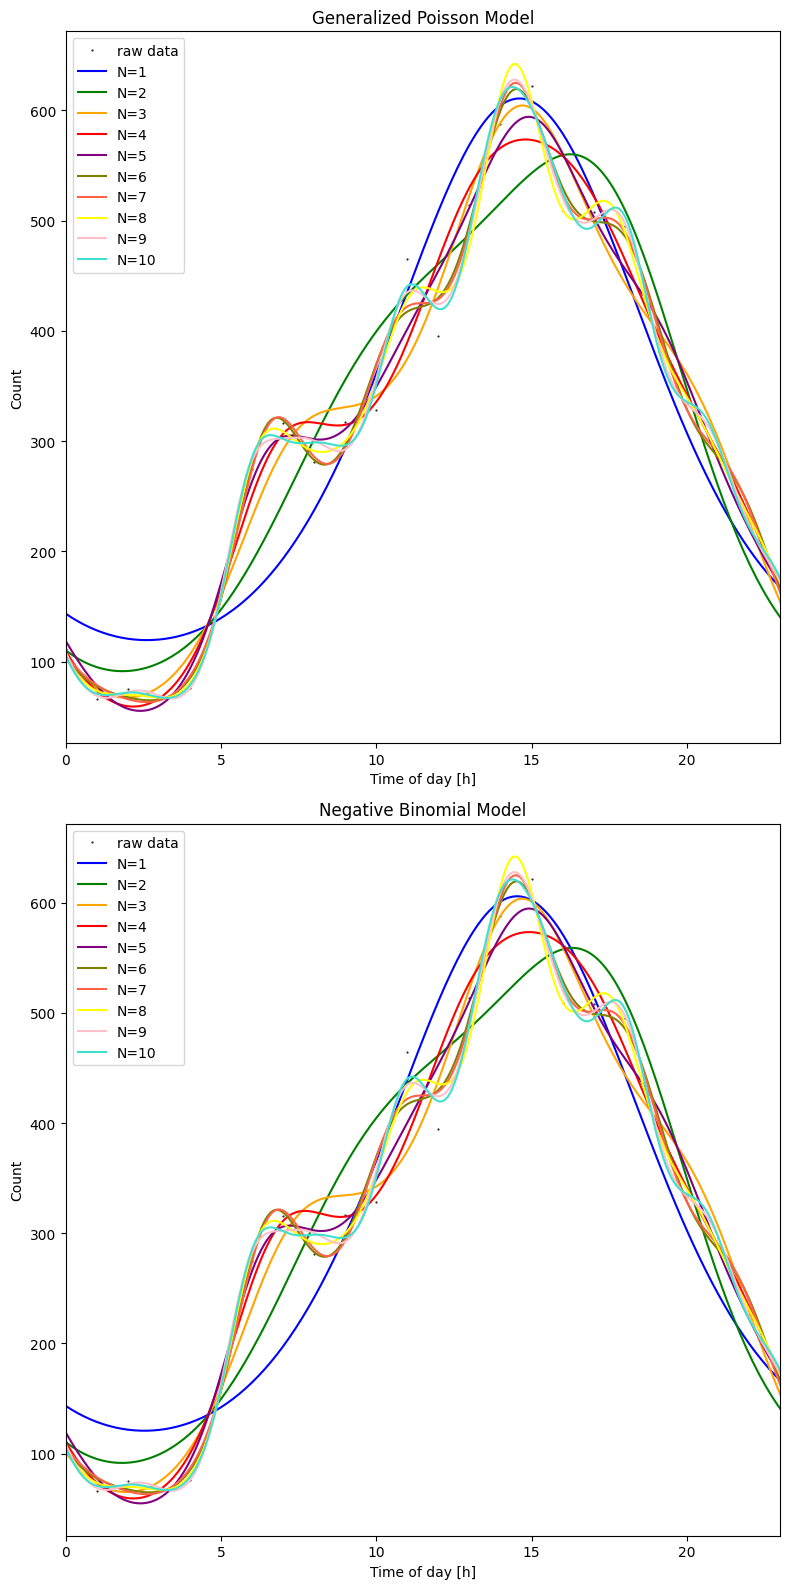

In [12]:
df_results_RC = dproc.fit_to_models(df_plot_RC, count_models, n_components, 24)

In [13]:
display(df_results_RC)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,log_likelihood,logs,mean(est),Y(est),X_test,Y_test
0,gen_poisson,1,245.68,365.11,[14.61],[610.78],1.784658e-12,72694.637814,271.658566,276.370781,-131.829283,"[-4.7377089671750525, -5.672110297580346, -4.9...",316.950836,"[143.4440375582008, 128.27256680646795, 120.67...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[143.4440375582008, 141.5512457044075, 139.745..."
1,gen_poisson,2,234.43,325.69,[16.22],[560.12],4.418793e-14,50799.236546,261.132911,268.201234,-124.566455,"[-4.284689967770291, -4.5747249026821635, -4.1...",316.016512,"[110.30484325405567, 94.9650627249715, 91.4122...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[110.30484325405567, 108.16441561196422, 106.1..."
2,gen_poisson,3,268.56,335.90,[14.71],[604.45],3.285423e-17,23033.879527,243.931397,253.355828,-113.965699,"[-3.86418894710134, -3.659701288699324, -3.721...",316.025678,"[102.8081071497615, 75.24686426353972, 67.3409...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[102.8081071497615, 99.01559185790474, 95.4675..."
3,gen_poisson,4,257.21,316.37,[14.81],[573.58],1.268614e-16,20197.909751,244.985860,256.766398,-112.492930,"[-3.4378132609758723, -3.4334633484042456, -4....",316.625000,"[109.93393438377011, 73.27219202394517, 59.457...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[109.93393438377011, 105.17650895838501, 100.6..."
4,gen_poisson,5,269.46,324.71,[14.91],[594.17],5.174528e-17,15765.023041,241.649726,255.786372,-108.824863,"[-3.6460788157201165, -3.847322905052124, -4.9...",316.625000,"[118.76400925628307, 77.99864255674804, 57.186...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[118.76400925628307, 114.05898139857472, 109.4..."
5,gen_poisson,6,277.30,342.13,[14.51],[619.43],3.864960e-19,8081.287145,229.761433,246.254186,-100.880716,"[-3.4049297728349615, -4.050860854180328, -3.4...",316.623165,"[104.53821734717928, 77.65071456656872, 67.510...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[104.53821734717928, 100.51847821552643, 96.84..."
6,gen_poisson,7,280.91,344.15,"[14.51, 17.32]","[625.05, 502.57]",2.616518e-18,7433.932038,232.927355,251.776217,-100.463678,"[-3.2796712556266954, -4.259624451053199, -3.7...",316.625000,"[106.51619723972222, 78.74677018921986, 65.830...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[106.51619723972222, 102.66723059691293, 99.10..."
7,gen_poisson,8,287.46,354.54,"[14.41, 17.32]","[642.0, 518.06]",1.055589e-18,6826.320526,230.043857,251.248826,-97.021928,"[-3.343061365477567, -3.4091942520215213, -3.1...",316.625000,"[105.36170501944972, 73.51839831406873, 69.841...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[105.36170501944972, 100.25009956420148, 95.57..."
8,gen_poisson,9,280.67,347.21,"[14.41, 17.52]","[627.88, 509.94]",1.204574e-18,5486.642676,229.630033,253.191110,-94.815016,"[-3.192991075672154, -2.983195468589315, -3.03...",316.625000,"[108.63254507428088, 68.84659710503034, 72.046...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[108.63254507428088, 102.34516556127825, 96.46..."
9,gen_poisson,10,277.15,344.10,"[14.41, 17.72]","[621.25, 511.89]",5.076118e-18,5015.121502,232.373725,258.290909,-94.186862,"[-3.330760673165443, -3.118507733114072, -3.04...",316.625000,"[105.55137485283808, 70.79666155797075, 71.843...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[105.55137485283808, 99.48406610075072, 93.982..."


## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [14]:
best_count_model = dproc.get_best_count_model(df_results_RC, 'Vuong')
print("Best model: {}".format(best_count_model.count_model))
best_model = dproc.get_best_n_components(df_results_RC, 'Vuong', count_model=best_count_model['count_model'])
print("Number of components: {}".format(best_model.n_components))

Best model: gen_poisson
Number of components: 6


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [15]:
best_n_components = dproc.get_best_n_components(df_results_RC, 'Vuong')
print("Number of components: {}".format(best_n_components.n_components))
best_model = dproc.get_best_count_model(df_results_RC, 'Vuong', n_components=best_n_components['n_components'])
print("Best model: {}".format(best_model.count_model))

Number of components: 6
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja

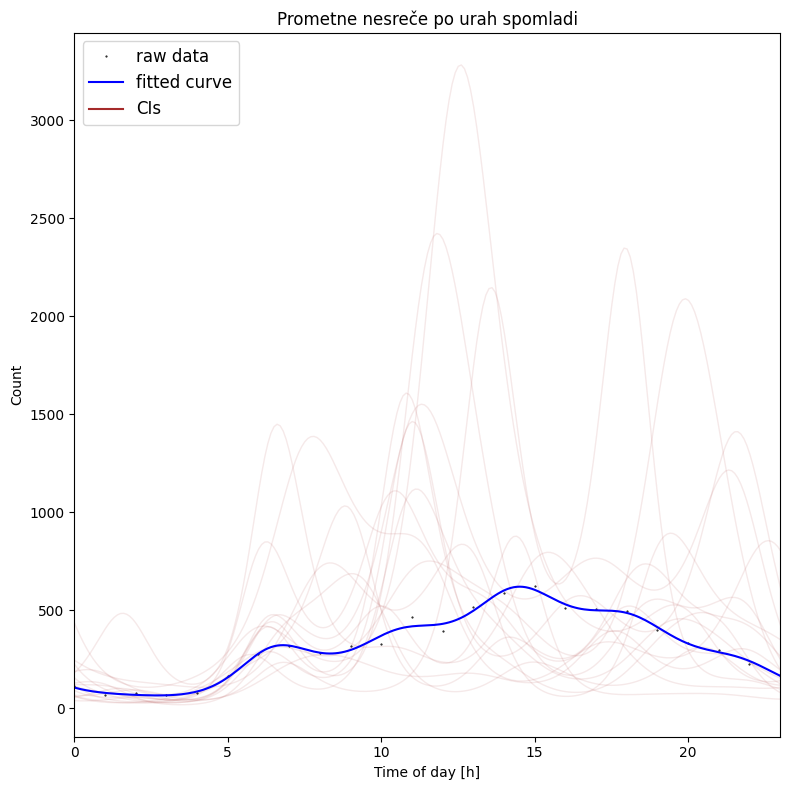

Intervali zaupanja:


,0,1
0,5.043400,5.940850
1,-1.223713,0.277163
2,-1.112265,-0.303546
3,-0.863268,0.312524
4,-0.526222,0.238824
5,-0.384071,-0.052061
6,-0.577880,0.527071
7,-0.406679,0.439040
8,-0.115443,0.362628
9,-0.229650,0.323030


In [16]:
# print(type(best_model))
# print(type(best_n_components))

# print(best_n_components)

count_model = best_model.count_model
n_components = int(best_n_components.n_components)

CIs = plot.plot_model(df_plot_RC, count_model, n_components, title='Prometne nesreče po urah spomladi', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs)

### Parametri izbranega modela

In [17]:
CIs_params = dproc.calculate_confidence_intervals_parameters(df_plot_RC, n_components, count_model, best_model['peaks'])
best_model = pd.concat([best_model, pd.Series(CIs_params)], axis=0)
best_model=best_model[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model.to_frame())

Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,6
amplitude,277.3
mesor,342.13
peaks,[14.51]
heights,[619.43]
amplitude_CIs,"[67.06, 598.68]"
mesor_CIs,"[131.28, 658.46]"
peaks_CIs,"[13.4, 14.98]"
heights_CIs,"[321.21, 1061.6]"
